In [57]:
import os
import nest_asyncio
import asyncpg
from pyspark.sql import SparkSession
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns


In [48]:
nest_asyncio.apply()

DB_CONFIG = {
    "user": os.getenv("POSTGRES_USER", "admin"),
    "password": os.getenv("POSTGRES_PASSWORD", "admin"),
    "database": os.getenv("POSTGRES_DB", "tender"),
    "host": os.getenv("POSTGRES_HOST", "postgre"),
    "port": int(os.getenv("POSTGRES_PORT", 5432))
}

async def read_table_as_df() -> pd.DataFrame:
    conn = await asyncpg.connect(**DB_CONFIG)
    rows = await conn.fetch("SELECT * FROM tenders")
    df = pd.DataFrame([dict(row) for row in rows])
    await conn.close()
    return df


In [49]:
tender_csv_name = "tender.csv"
tender_csv_path = Path.cwd() / tender_csv_name

if not tender_csv_path.is_file():
    df = await read_table_as_df()
    df.to_csv(tender_csv_path, index=False)
    print(f"Saved tender data to: {tender_csv_path}")
else:
    print(f"{tender_csv_name} already exists at: {tender_csv_path}")


tender.csv already exists at: c:\Users\SillySharp\source\repos\projektmunka_III\spark-shared-storage\tender.csv


In [50]:
spark = SparkSession.builder \
                    .appName("File_to_spark") \
                    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

In [51]:
df = spark.read.csv(tender_csv_path.as_posix(), header=True, inferSchema=True)

df.show()
df.printSchema()

+--------------------+--------------------+--------------------+-------------+--------------------+-------------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------------+--------------------+--------------------+--------------------+--------------------+
|                 _c0|                  id|                date|deadline_date|               title|     category|         description|               phase|               place|       awarded_value|   awarded_currency|       awarded_date|      suppliers_name|               count|        offers_count|        request_json|
+--------------------+--------------------+--------------------+-------------+--------------------+-------------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------------+--------------------+--------------------+--------------------+--------------------+
|                   0|            

In [52]:
df = df.drop("request_json", "_c0", "id")
df = df.dropna()

print(df.count())
df.show()

98
+--------------------+--------------------+--------------------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+
|                date|       deadline_date|               title|     category|         description|               phase|               place|       awarded_value|    awarded_currency|       awarded_date|      suppliers_name|               count|        offers_count|
+--------------------+--------------------+--------------------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+
|          2021-10-17|          2021-10-25|Tenki Csicsergő Ó...|constructions|Kiegészítő építés...|E60 - Szerződéskö...|         HU312 Heves|          10590000.0|                 HUF|         2021

In [53]:
from pyspark.sql.functions import col
from pyspark.sql.types import IntegerType, FloatType, DateType, StringType

columns_to_cast = {
    "id": IntegerType(),
    "date": DateType(),
    "deadline_date": DateType(),
    "title": StringType(),
    "category": StringType(),
    "description": StringType(),
    "phase": StringType(),
    "place": StringType(),
    "awarded_value": FloatType(),
    "awarded_currency": StringType(),
    "awarded_date": DateType(),
    "suppliers_name": StringType(),
    "count": IntegerType(),
    "offers_count": IntegerType()
}

for column, data_type in columns_to_cast.items():
    try:
        df = df.withColumn(column, col(column).cast(data_type))
    except Exception as e:
        print(f"Error casting {column}: {e}")
        df = df.drop(column)
    
    
df = df.dropna()
print(df.count())
df.printSchema()
df.show()

Error casting id: [UNRESOLVED_COLUMN.WITH_SUGGESTION] A column or function parameter with name `id` cannot be resolved. Did you mean one of the following? [`date`, `title`, `count`, `phase`, `place`].;
'Project [date#4669, deadline_date#4670, title#4671, category#4672, description#4673, phase#4674, place#4675, awarded_value#4676, awarded_currency#4677, awarded_date#4678, suppliers_name#4679, count#4680, offers_count#4681, cast('id as int) AS id#4904]
+- Filter atleastnnonnulls(13, date#4669, deadline_date#4670, title#4671, category#4672, description#4673, phase#4674, place#4675, awarded_value#4676, awarded_currency#4677, awarded_date#4678, suppliers_name#4679, count#4680, offers_count#4681)
   +- Project [date#4669, deadline_date#4670, title#4671, category#4672, description#4673, phase#4674, place#4675, awarded_value#4676, awarded_currency#4677, awarded_date#4678, suppliers_name#4679, count#4680, offers_count#4681]
      +- Relation [_c0#4667,id#4668,date#4669,deadline_date#4670,title#

In [54]:
df = df.filter(df.awarded_currency == "HUF") \
       .orderBy("date", "deadline_date")

print(df.count())
df.show(df.count(), truncate=False)

44
+----------+-------------+------------------------------------------------------+-------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

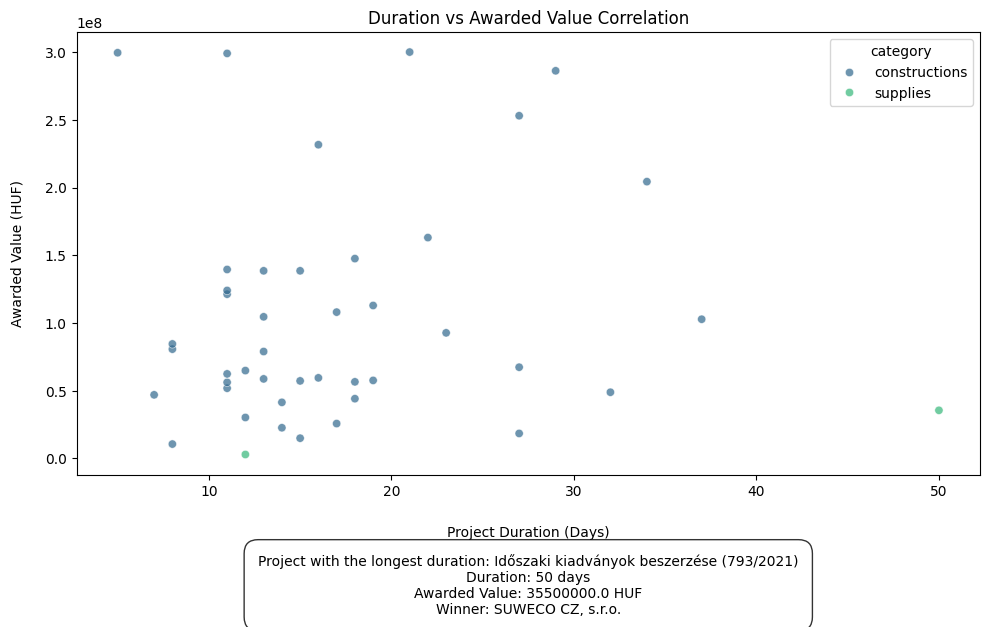

In [69]:
pdf = df.toPandas()

pdf['date'] = pd.to_datetime(pdf['date'])
pdf['deadline_date'] = pd.to_datetime(pdf['deadline_date'])

pdf['duration'] = (pdf['deadline_date'] - pdf['date']).dt.days

max_duration_project = pdf.loc[pdf['duration'].idxmax()]

correlation = pdf[['duration', 'awarded_value']].corr()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=pdf, x='duration', y='awarded_value', hue='category', palette='viridis', alpha=0.7)


plt.title('Duration vs Awarded Value Correlation')
plt.xlabel('Project Duration (Days)', labelpad=20)
plt.ylabel('Awarded Value (HUF)', labelpad=15)

plt.annotate(f"Project with the longest duration: {max_duration_project['title']}\n"
             f"Duration: {max_duration_project['duration']} days\n"
             f"Awarded Value: {max_duration_project['awarded_value']} HUF\n"
             f"Winner: {max_duration_project['suppliers_name']}",
             xy=(0.5, -0.25), xycoords='axes fraction', ha='center', va='center', 
             fontsize=10, bbox=dict(facecolor='white', alpha=0.8, edgecolor='black', boxstyle='round,pad=1'))


plt.tight_layout()
plt.subplots_adjust(bottom=0.2)

plt.show()


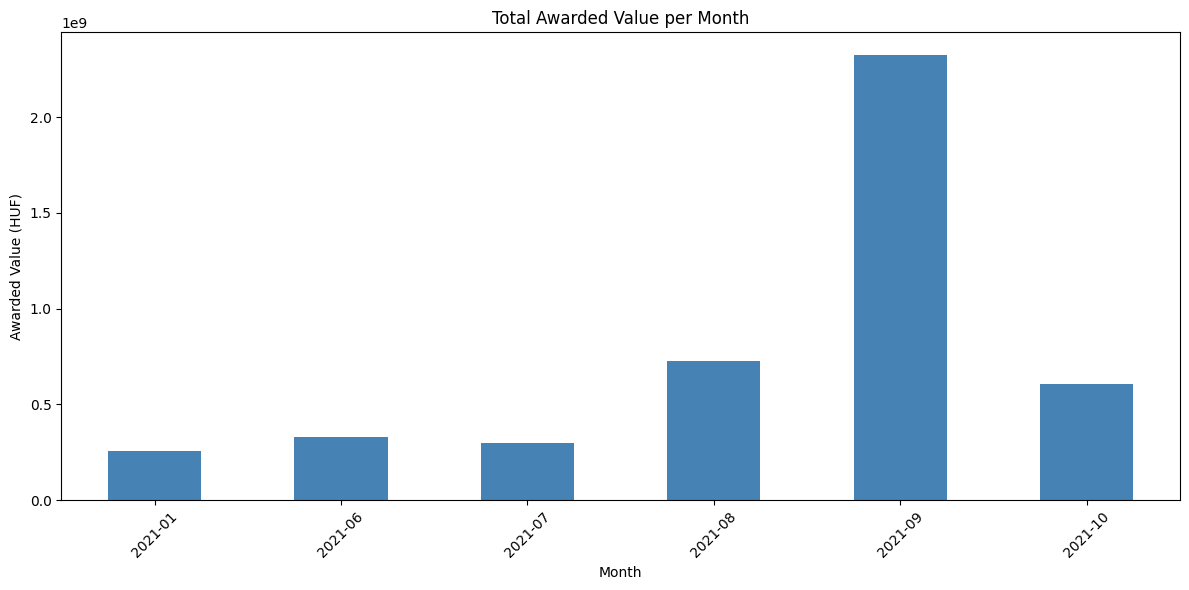

In [ ]:
pdf['year_month'] = pdf['date'].dt.to_period('M')
monthly_awards = pdf.groupby('year_month')['awarded_value'].sum()

monthly_awards.plot(kind='bar', figsize=(12, 6), color='steelblue')
plt.title("Total Awarded Value per Month")
plt.ylabel("Awarded Value (HUF)")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

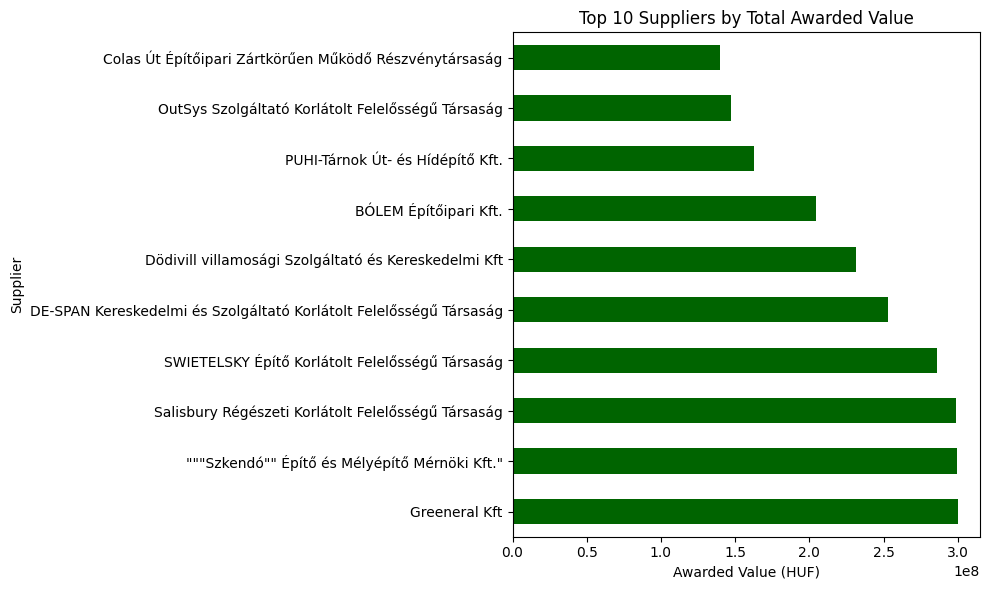

In [71]:
top_suppliers = pdf.groupby('suppliers_name')['awarded_value'].sum().nlargest(10)

top_suppliers.plot(kind='barh', figsize=(10, 6), color='darkgreen')
plt.title("Top 10 Suppliers by Total Awarded Value")
plt.xlabel("Awarded Value (HUF)")
plt.ylabel("Supplier")
plt.tight_layout()
plt.show()
